# Лабораторная работа №8: Парсинг сайтов и анализ текстовой информации

*Данные*: раздел техники на сайте [irecommend.ru/catalog/list/3](https://irecommend.ru/catalog/list/3)

### Загрузка пакетов

In [16]:
import re
import nltk
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep
from random import randint
from pymystem3 import Mystem
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from nltk.probability import FreqDist
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Загрузка и проверка данных

In [6]:
count_pages = 30
products_per_page = 20

products_info = []

for page_num in range(0, count_pages):
    url = f'https://irecommend.ru/catalog/list/3?page={page_num}'
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    
    products = soup.find_all('div', class_='ProductTizer plate teaser-item')

    for product in products:
        title = product.find('div', class_='title').text
        mean_rating = product.find('span', class_='average-rating').find('span').text
        likes_count = product.find('span', class_='RecommendRating-like').find('span').text
        dislikes_count = product.find('span', class_='RecommendRating-dislike').find('span').text
        feedback_count = product.find('span', class_='counter').text
        products_info.append((title, mean_rating, likes_count, dislikes_count, feedback_count))

    print(f'{page_num+1}✓', end=' ')
    sleep(randint(7, 9))

if len(products_info) == count_pages*products_per_page:
    print('All elements are parsed')
    df = pd.DataFrame(products_info, columns=['title', 'mean_rating', 'likes_count', 'dislikes_count', 'feedback_count'])
else:
    print('Something went wrong, count of products_info less or more than expected')

1✓ 2✓ 3✓ 4✓ 5✓ 6✓ 7✓ 8✓ 9✓ 10✓ 11✓ 12✓ 13✓ 14✓ 15✓ 16✓ 17✓ 18✓ 19✓ 20✓ 21✓ 22✓ 23✓ 24✓ 25✓ 26✓ 27✓ 28✓ 29✓ 30✓ All elements are parsed


In [7]:
df.head()

,title,mean_rating,likes_count,dislikes_count,feedback_count
0,Микроволновая печь Candy CPMW2070M,5,1,0,1
1,Графический планшет Xp-pen XPPen G-640,5,1,0,1
2,Оператор мобильной связи Tele2 / Теле2,2.5,509,844,1353
3,Умные часы Apple Watch Series 3,4.7,138,11,149
4,Приложение Магнит,3.8,49,11,60


### Первичный анализ данных

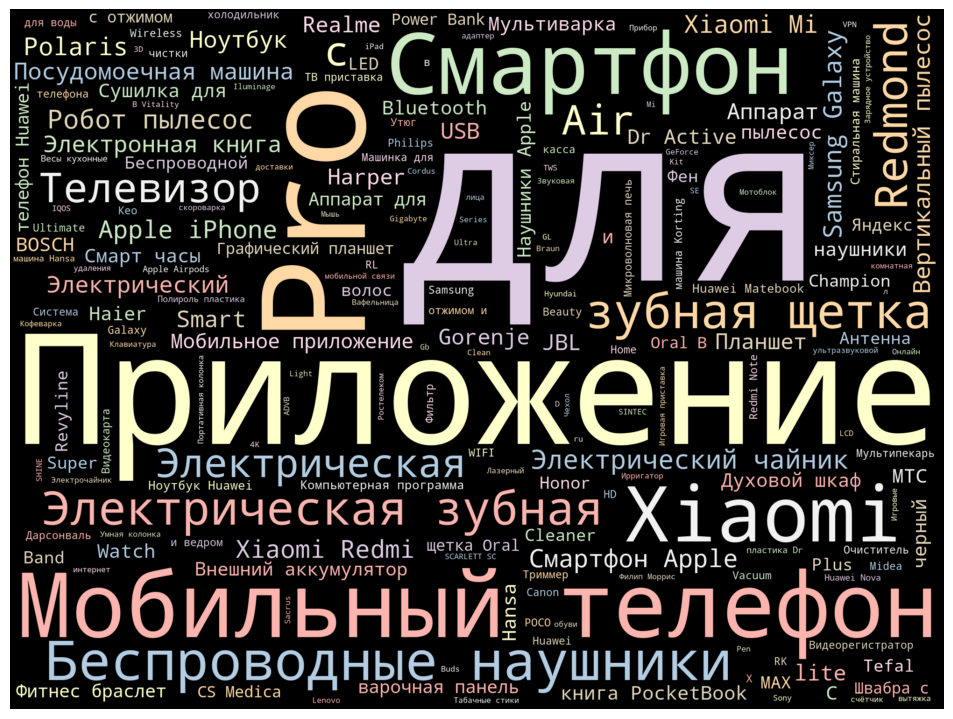

In [8]:
wordcloud = WordCloud(width=2000, height=1500, background_color='black',
                      colormap='Pastel1', min_font_size=15, margin=15).generate(' '.join(df['title']))

plt.figure(figsize=(15, 7), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Можно заметить насколько часто используется слово "для" или поменьше "с" в названиях товаров. Необходимо привести данные к нижнему регистру, почистить от стоп-слов, знаков препинания, одиночных чисел и символов, а также привести к нормальной форме.

### Обработка данных

In [9]:
stop_words = stopwords.words("russian")
m = Mystem()

def clean_title_lemmatize(title):
    title = title.lower()
    title = re.sub(r'[^\w\s]', '', title)
    title = re.sub(r'\b\d+\b', '', title)
    title = re.sub(r'\b\w{1,2}\b', '', title)
    words = word_tokenize(title)
    words = [word for word in words if word not in stop_words]
    title = ' '.join(words)
    lemmas = m.lemmatize(title)
    return ''.join(lemmas).replace('\n', '')

In [10]:
df['title'] = df['title'].apply(clean_title_lemmatize)

In [11]:
df.head()

,title,mean_rating,likes_count,dislikes_count,feedback_count
0,микроволновый печь candy cpmw2070m,5,1,0,1
1,графический планшет xppen xppen g640,5,1,0,1
2,оператор мобильный связь tele2 теле2,2.5,509,844,1353
3,умный часы apple watch series,4.7,138,11,149
4,приложение магнит,3.8,49,11,60


### Анализ после обработки

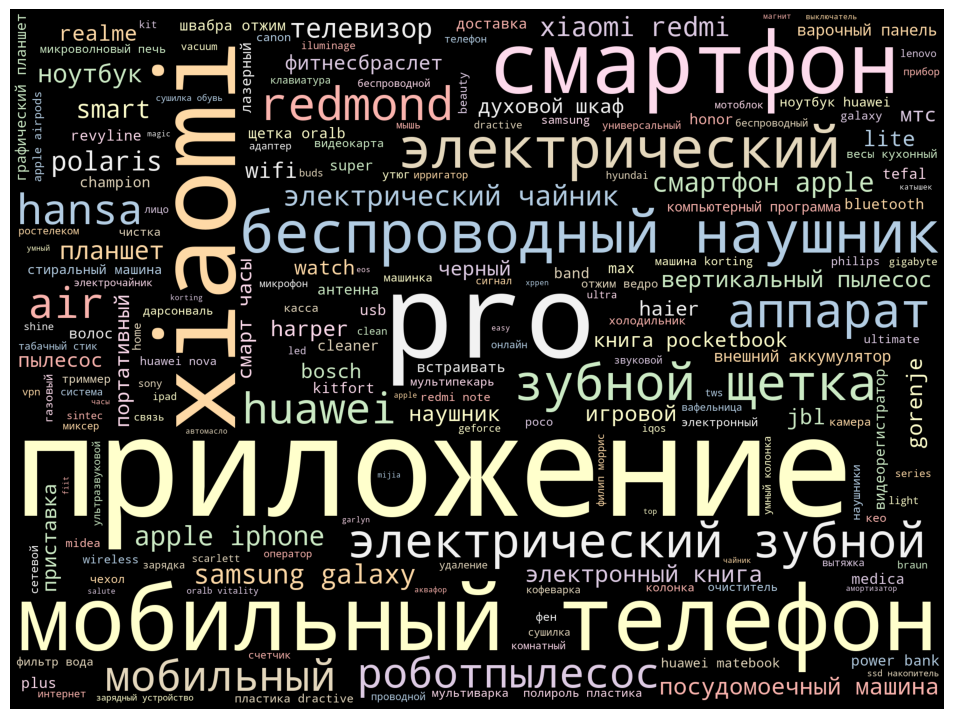

In [12]:
wordcloud = WordCloud(width=2000, height=1500, background_color='black',
                      colormap='Pastel1', min_font_size=15, margin=15).generate(' '.join(df['title']))

plt.figure(figsize=(15, 7), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Теперь можем видеть, допустим, что удалились ненужные частицы. Чаще всего встречаются категории техники или бренды

Частотный анализ слов

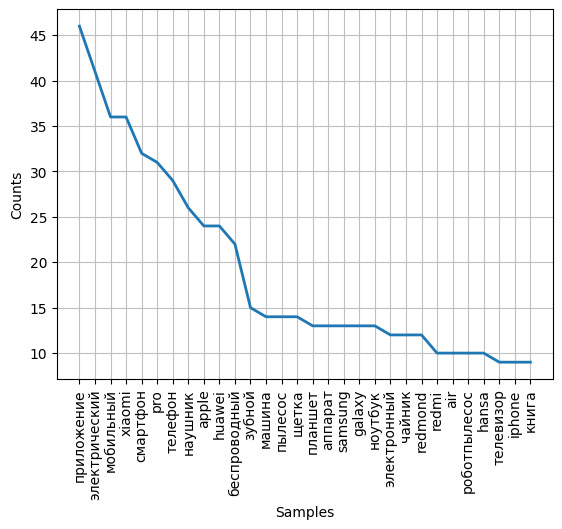

In [13]:
fdist = FreqDist()

for title in df['title']:
    for word in title.split():
        fdist[word] += 1

fdist.plot(30)
plt.show()

Скорее всего, разделение может быть произведено по приложениям, мобильным телефонам, наушникам, зубным щёткам, пылесосам, планшетам, ноутбукам, чайникам, робот-пылесосам, элекронным книгам, либо по брендам, например, Xiaomi, Apple, Samsung, Redmi

### Разделение с помощью TfidVectorizer и CountVectorizer

In [14]:
titles = df['title']

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(df['title'])

n_clusters = 10
tfidf_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
tfidf_clusters = tfidf_kmeans.fit_predict(tfidf_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(titles[tfidf_clusters == i])
    print()

Cluster 1:
119    внешний аккумулятор xiaomi беспроводный wirele...
125    внешний аккумулятор xiaomi беспроводный wirele...
154    внешний аккумулятор borofone беспроводный заря...
204    внешний аккумулятор xiaomi power bank ultra co...
254             внешний аккумулятор redmi power bank mah
374            внешний аккумулятор xiaomi power bank mah
Name: title, dtype: object

Cluster 2:
0                     микроволновый печь candy cpmw2070m
1                   графический планшет xppen xppen g640
8      электронный сигарета филип моррис табачный сти...
9                                            nikon d3200
10                            bluetooth колонка jbl flip
                             ...                        
593    паровой очиститель kitfort kt931 фиолетовыйчерный
594                             ломтерезка gorenje r506e
595            встраивать посудомоечный машина hansa zim
597                          ledтелевизор dexp h24g8100c
599                          смарт час

In [17]:
count_vectorizer = CountVectorizer()
count_vectors = count_vectorizer.fit_transform(titles)

count_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
count_clusters = count_kmeans.fit_predict(count_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(titles[count_clusters == i])
    print()

Cluster 1:
258    ноутбук lenovo ideapad s14515api
311      ноутбук lenovo ideapad 15are05
Name: title, dtype: object

Cluster 2:
107    электрический зубной щетка oralb crossaction p...
130                  электрический зубной щетка revyline
152    электрический зубной щетка oralb vitality d100...
206              электрический зубной щетка polaris petb
243      электрический зубной щетка oralb vitality white
249    центр уход полость рот braun домашний зубной ц...
250            электрический зубной щетка revyline rl040
360         электрический зубной щетка revyline звуковой
378            электрический зубной щетка oralb vitality
400    электрический зубной щетка acleon f36 black ed...
404     электрический зубной щетка medica sonicmax cs167
438    электрический звуковой зубной щетка medica kid...
572    электрический зубной щетка medica kids cs463g ...
Name: title, dtype: object

Cluster 3:
7            беспроводный наушник xiaomi redmi buds lite
12     машинка удаление катышек x

TfidfVectorizer в большинстве случаях всегда будет давать более хорошие результаты, так как он учитывает не только частоту слов, но и их важность в тексте.
Примерные его группы разбиения:
1. Внешние аккумуляторы
2. Во второй кластер, скорее всего, попали все товары, которые не попали в любые другие
3. Смартфоны
4. Беспроводные наушники
5. Электрические приборы, в особенности щётки и плиты
6. В большинстве техника Apple, кроме смартфонов с 3 кластера
7. Мобильные телефоны (потому что записаны не как смартфоны) или операторы связи
8. Чайники
9. Мультипекари, мультиварки и другая техника Redmond
10. Мобильные приложения

### Визуализация разбиения

In [19]:
def make_cooccurrence_matrix(texts):
  # Зададим словарь и попарную частоту совместной встречаемости слов
  vocabulary = set(texts[0].split())
  for t in texts[1:]:
    vocabulary = vocabulary.union(set(t.split()))
  vocabulary=list(vocabulary)

  N = len(vocabulary)
  
  # Задаём cooccurrence matrix
  cooccurrence = np.zeros((N,N))
  for i in range(N):
    for j in range(i, N):
      if i == j:
        continue
      for t in texts:
        if vocabulary[i] in t.split() and vocabulary[j] in t.split():
          cooccurrence[i][j]+=1
          cooccurrence[j][i]+=1
  return cooccurrence, vocabulary

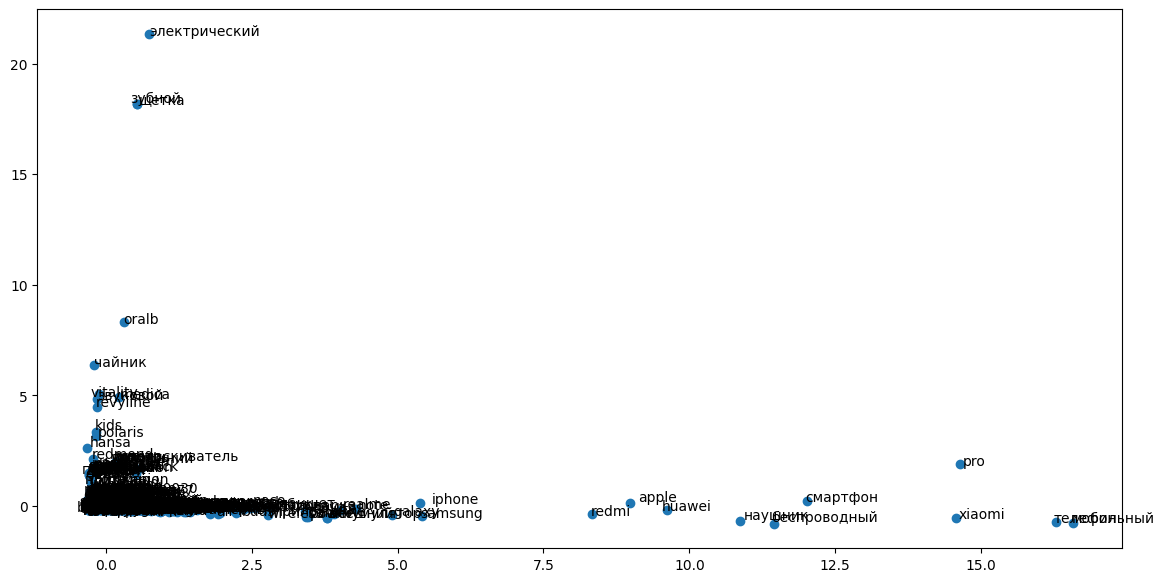

In [21]:
text_list = df['title'].tolist()

c, v = make_cooccurrence_matrix(text_list)

p = PCA(n_components=2)
pca = p.fit_transform(c)

plt.figure(figsize=(14,7))
ax = plt.gca()
for i, c in enumerate(pca):
    ax.annotate(text = v[i], xy = (c[0] + np.random.randn()/15, c[1]+ np.random.randn()/15))
plt.scatter(pca[:,0], pca[:,1])
plt.show()

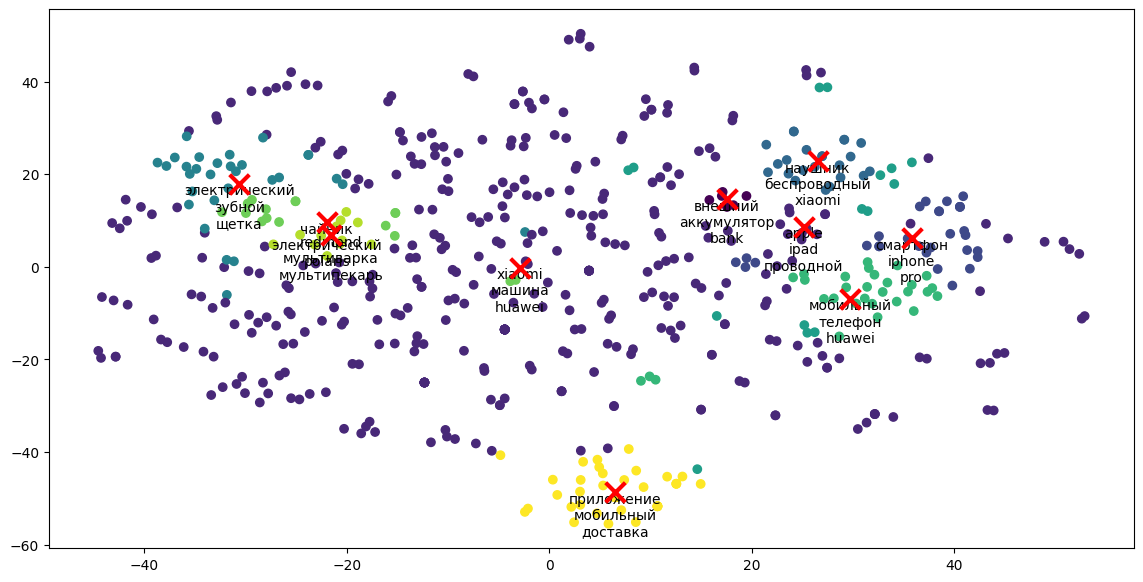

In [22]:
tsne = TSNE(n_components=2)
reduced_vectors = tsne.fit_transform(tfidf_vectors.toarray())

centroids = np.zeros((n_clusters, 2))
for i in range(n_clusters):
    centroids[i] = np.mean(reduced_vectors[tfidf_clusters == i], axis=0)

plt.figure(figsize=(14, 7))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=tfidf_clusters)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3, color='r', zorder=10)

for i in range(n_clusters):
    cluster_words = tfidf_vectors[tfidf_clusters == i].toarray().sum(axis=0)
    top_words_indices = cluster_words.argsort()[-3:][::-1]
    top_words = [tfidf_vectorizer.get_feature_names_out()[index] for index in top_words_indices]
    plt.annotate('\n'.join(top_words), (centroids[i, 0], centroids[i, 1]), ha='center', va='top')

plt.show()

### Подсчёт характеристик

In [23]:
df['mean_rating'] = df['mean_rating'].astype(float)
df['likes_count'] = df['likes_count'].astype(int)
df['dislikes_count'] = df['dislikes_count'].astype(int)
df['feedback_count'] = df['feedback_count'].astype(int)

df['cluster'] = tfidf_clusters

In [24]:
title_count = df.groupby('cluster')['title'].count()
mean_rating = df.groupby('cluster')['mean_rating'].mean()
mean_likes = df.groupby('cluster')['likes_count'].mean()
mean_dislikes = df.groupby('cluster')['dislikes_count'].mean()
mean_feedback = df.groupby('cluster')['feedback_count'].mean()
sum_likes = df.groupby('cluster')['likes_count'].sum()
sum_dislikes = df.groupby('cluster')['dislikes_count'].sum()
sum_feedback = df.groupby('cluster')['feedback_count'].sum()

stats_df = pd.concat([title_count, mean_rating, mean_likes, mean_dislikes, mean_feedback, sum_likes, sum_dislikes, sum_feedback], axis=1)
stats_df.columns = ['title_count', 'mean_rating', 'mean_likes', 'mean_dislikes', 'mean_feedback', 'sum_likes', 'sum_dislikes', 'sum_feedback']

stats_df

,title_count,mean_rating,mean_likes,mean_dislikes,mean_feedback,sum_likes,sum_dislikes,sum_feedback
cluster,,,,,,,,
0,6,4.700000,18.500000,0.666667,19.166667,111,4,115
1,393,4.498982,15.256997,9.251908,24.801527,5996,3636,9747
2,30,4.580000,77.200000,6.566667,84.100000,2316,197,2523
3,23,4.447826,16.695652,1.739130,18.521739,384,40,426
4,30,4.703333,10.466667,0.466667,17.666667,314,14,530
5,15,4.573333,47.266667,4.866667,52.200000,709,73,783
6,30,4.303333,69.200000,96.000000,165.200000,2076,2880,4956
7,16,4.756250,9.125000,0.625000,13.875000,146,10,222
8,12,4.283333,17.500000,0.833333,18.333333,210,10,220


Как итог, у нас не так много товаров, чтобы точно соотносить их к множеству групп. Но можно сказать, что в основном разбиение произошло по категориям техники или брендам
Судить по усредняющим характеристикам кластеров не особо можно, так как количество товаров, которые попадают в них сильно отличаются, в 2-7 раза (если не учитывать второй)
Точно можно сказать, что чаще всего оценивают, при этом положительно, смартфоны (2 кластер) и мобильные телефоны (6 кластер, но тоже можно соотнести к 2). Так как в 6 кластер попадают ещё операторы связи, то видимо все негативные отзывы этого кластера относятся к ним :d. И также мобильные приложения, их тоже любят оценивать, и почти в половине случаев отрицательно
Наилучший средний рейтинг товаров имеет категория чайников (7 кластер), а худший - приложения (9 кластер)
Наилучшее соотношение лайков к дизлайкам имеют внешние аккумуляторы (0 кластер), но там не так и много товаров. В других случаях это скорее всего будут электрические щётки и плиты (4 кластер) 
